In [2]:
import IPython.display

IPython.display.display(
    IPython.display.HTML(
        data="""\
    <style>
        div#notebook-container    { width: 100%; }
        div#menubar-container     { width: 100%; }
        div#maintoolbar-container { width: 100%; }
    </style>
        """
    )
)

# Probability of a 2x2 contigency table conditioned on fixed marginals

For a 2x2 contigency table

\begin{align*}
\begin{bmatrix}
a & b \\ 
c & d
\end{bmatrix}
\end{align*}


If the marginals ($a + b$, $c + d$, and $a + c$) are fixed, which implies $b + d$ is also fixed, then there is only one degree of freedom. Without loss of generality, let $A$ be the random variable, then the probability of observing a particular table of counts is 

\begin{align*}
\mathbb{P}(A=a)
&= \frac{\binom{a + b}{a} \binom{c + d}{c} (a + c)! (b + d)!}{(a + b + c + d)!} \\
&= \frac{\binom{a + b}{a} \binom{c + d}{c}}{\binom{a + b + c + d}{a + c}} 
\end{align*}


Note,

* the $(a + c)!$ and $(b+d)!$ accounts for all the permutations of $a + b$ elements.
* the 2nd equality shows $A$ follows a hypergeometric distribution. (Consider $a + b$ ane $c + d$ two groups, $a$ and $c$ are of a particular element type and $b$ and $d$ are of another element type)

# Support analysis

if we add $\delta$ to $a$, keeping marginals fixed, it becomes

\begin{align*}
\begin{bmatrix}
a + \delta & b - \delta \\ 
c - \delta & d + \delta
\end{bmatrix}
\end{align*}

which need to satisfy

\begin{align*}
a + \delta &\ge 0 \\
b - \delta &\ge 0 \\ 
c - \delta &\ge 0 \\
d + \delta &\ge 0
\end{align*}


Therefore,

\begin{align*}
\delta &\le \min(b, c) \\
\delta &\ge \max(-a, -d) = - \min(a, d) \\ 
\end{align*}


Take the example of $\begin{bmatrix}
6 & 2 \\ 
1 & 4 \end{bmatrix}$ from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html) for example, $1 \ge \delta \ge -4$, which corresponds to $7 \ge a \ge 2$.

Equivalently,

\begin{align*}
a + \max(-a, -d) &\le a + \delta \le a + \min(b, c) \\
\max(0, a - d) &\le a + \delta \le \min(a + b, a + c)
\end{align*}

If we use a different set of symbol more commonly used in literature, e.g. https://sci-hub.ru/https://www.jstor.org/stable/2333309, to represent the contigency table:

\begin{align*}
\begin{matrix}
\text{Group} & \text{With attribute} & \text{Without attribute} & \text{Total} \\
1 & a & A - a & A \\ 
2 & b & B - b & B \\
\text{Total} & r = a + b & N - r & N
\end{matrix}
\end{align*}


Then the above inequalities become

\begin{align*}
\max(0, r - B) &\le a + \delta \le \min(r, A)
\end{align*}

Note, the exchange of notations for $b$ and $c$ does NOT change the support for $a$.

# The hypothesis test

With the conditional probability and the support analysis result, a hypothesis test can be derived from such probabilities. 

Suppose $H_0: \frac{a}{a + b} \ge \frac{c}{c + d}$ and $H_1: \frac{a}{a + b} < \frac{c}{c + d}$, then a p value, which is defined as the probability of observing the current counts or more extreme ones under the null, can be calculated as 

\begin{align*}
p 
&= \mathbb{P}(a \le A \le a + \min(b, c)) \\
&= \sum_{i=a}^{\min(b, c)} \mathbb{P}(A=i)
\end{align*}

Similarly, if $H_0: \frac{a}{a + b} \le \frac{c}{c + d}$ and $H_1: \frac{a}{a + b} > \frac{c}{c + d}$, then the p value can be calculated as

\begin{align*}
p 
&= \mathbb{P}(a -\min(a, d) \le A \le a) \\
&= \sum_{i=-\min(a, d)}^{a} \mathbb{P}(A=i)
\end{align*}

If the null is $H_0: \frac{a}{a + b} = \frac{c}{c + d}$ and $H_1: \frac{a}{a + b} \neq \frac{c}{c + d}$, the p value can be calculated as 

\begin{align*}
p 
&= \mathbb{P}(a -\min(a, d) \le A \le a + \min(b, c)) \\
&= \sum_{i=-\min(a, d)}^{a + \min(b, c)} \mathbb{P}(A=i) \mathbb{I}(\mathbb{P}(A=i) \le \mathbb{P}(A=a))
\end{align*}

where $\mathbb{I}$ is the indicator function, so the two-sided p value is the sum of probabilities which are smaller than $\mathbb{P}(A = a))$, i.e. the probability of observing the current counts.

# Demo

A demo is available at https://gist.githubusercontent.com/zyxue/f2e79bbd0712b4d186e3f9c0a4e38db4/raw/2b4a647d06e48eec569368ef5393232a1af4fccd/fisher_exact_naive.py that shows the above caluclation of p-values matches the implementation in [scipy.stats.fisher_exact](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html).

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import time
import scipy.stats
from tqdm import tqdm

# Scaling analysis

In [2]:
latencies = []
for i in tqdm(range(5000)):
    a = np.random.randint(1e6, 1e9)
    b = np.random.randint(1e6, 1e9)
    c = np.random.randint(1e6, 1e9)
    d = np.random.randint(1e6, 1e9)

    beg = time.monotonic_ns()
    scipy.stats.chi2_contingency([[5000, int(10e7)], [1000, int(10e7)]])
    latencies.append(("chi2", time.monotonic_ns() - beg))

    beg = time.monotonic_ns()
    scipy.stats.fisher_exact([[5000, int(10e7)], [1000, int(10e7)]])
    latencies.append(('fisher', time.monotonic_ns() - beg))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 678.90it/s]


In [3]:
df_plot = pd.DataFrame(latencies, columns=["label", "latency"]).assign(
    latency_ms=lambda df: df.latency / 1e6
)

In [16]:
df_plot.groupby('label').latency_ms.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
chi2,5000.0,0.248711,0.033596,0.227846,0.233747,0.237153,0.245431,0.630950
fisher,5000.0,1.193939,0.093467,1.127969,1.148906,1.160344,1.180918,2.051796


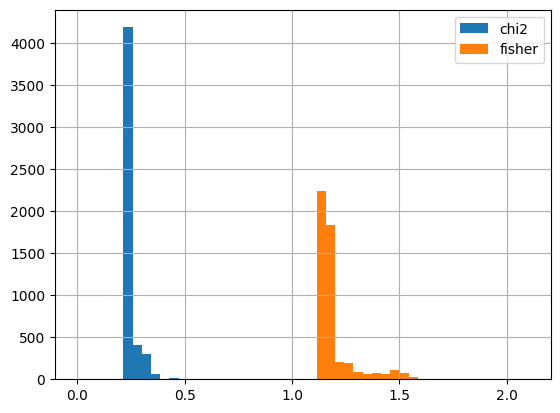

In [15]:
fig, ax = plt.subplots(1, 1)
for label in ["chi2", "fisher"]:
    _ = ax.hist(
        df_plot.loc[lambda df: df.label == label].latency_ms,
        bins=np.linspace(0, 2.1, 50),
        label=label,
    )
ax.grid()
ax.legend()

So chi2 is mucher by about 10x, but fisher's exact is not very slow either, typically < 2ms.